# Lesson 1

- https://course.fast.ai/Lessons/lesson1.html

In [ ]:
#!pip install -U duckduckgo_search

In [ ]:
from duckduckgo_search import DDGS
from fastcore.all import *

from fastdownload import download_url
from fastai.vision.all import *

## Load Data

In [ ]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(DDGS().images(keywords=term, max_results=max_images)).itemgot('image')

Let's start by searching for a bird photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [ ]:
data_path = Path("./data/lesson1")
data_path.mkdir(parents=True, exist_ok=True)

Searching for 'bird photo'


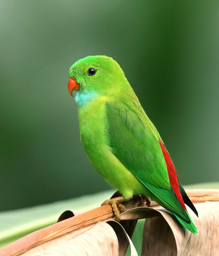

In [ ]:
bird_urls = search_images('bird photo', max_images=1)
download_url(bird_urls[0], data_path/"bird.jpg", show_progress=False)
im = Image.open(data_path/"bird.jpg")
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'forest photo'


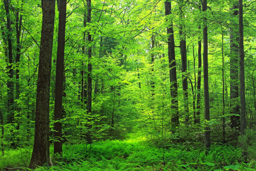

In [ ]:
forest_urls = search_images('forest photo', max_images=1)
download_url(forest_urls[0], data_path/"forest.jpg", show_progress=False)
im = Image.open(data_path/"forest.jpg")
im.to_thumb(256,256)

Now let's do the same with "cat photo", "dog photo", and "wolf photo":

Searching for 'cat photo'


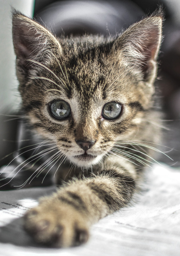

In [ ]:
cat_urls = search_images('cat photo', max_images=1)
download_url(cat_urls[0], data_path/"cat.jpg", show_progress=False)
im = Image.open(data_path/"cat.jpg")
im.to_thumb(256,256)

Searching for 'dog photo'


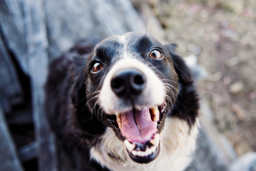

In [ ]:
dog_urls = search_images('dog photo', max_images=1)
download_url(dog_urls[0], data_path/"dog.jpg", show_progress=False)
im = Image.open(data_path/"dog.jpg")
im.to_thumb(256,256)

Searching for 'wolf photo'


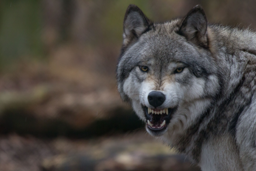

In [ ]:
wolf_urls = search_images('wolf photo', max_images=1)
download_url(wolf_urls[0], data_path/"wolf.jpg", show_progress=False)
im = Image.open(data_path/"wolf.jpg")
im.to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each, and save each group of photos to a different folder (I'm also trying to grab a range of lighting conditions here):

In [ ]:
searches = 'forest','bird','cat','dog','wolf'
imgs_path = data_path/"imgs"
from time import sleep

for o in searches:
    dest = imgs_path/f"{o}"
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} photo sun'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} photo shade'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest photo sun'
Searching for 'forest photo shade'
Searching for 'bird photo'
Searching for 'bird photo sun'
Searching for 'bird photo shade'
Searching for 'cat photo'
Searching for 'cat photo sun'
Searching for 'cat photo shade'
Searching for 'dog photo'
Searching for 'dog photo sun'
Searching for 'dog photo shade'
Searching for 'wolf photo'
Searching for 'wolf photo sun'
Searching for 'wolf photo shade'


## Train Model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(imgs_path))
failed.map(Path.unlink)
len(failed)

14

To train a model, we'll need `DataLoaders`, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a `DataBlock`, and view sample images from it:

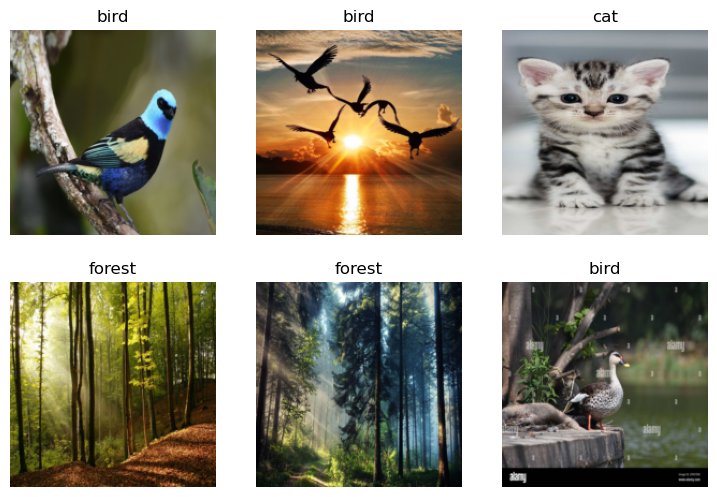

In [ ]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                get_items=get_image_files, 
                splitter=RandomSplitter(valid_pct=0.2, seed=0),
                get_y=parent_label,
                item_tfms=[Resize(192, method="squish")]
               ).dataloaders(imgs_path)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

---
`blocks=(ImageBlock, CategoryBlock),` - The inputs to our model are images, and the outputs are categories (in this case, "forest", "bird", "cat", "dog" or "wolf").

---
`get_items=get_image_files,` - To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).

---
`splitter=RandomSplitter(valid_pct=0.2, seed=42),` - Split the data into training and validation sets randomly, using 20% of the data for the validation set.

---
`get_y=parent_label,` - The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be "forest", "bird", "cat", "dog" or "wolf").

---
`item_tfms=[Resize(192, method='squish')]` - Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

---

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.004911,0.474476,0.192771,00:49


epoch,train_loss,valid_loss,error_rate,time
0,0.505954,0.225417,0.096386,00:48
1,0.326397,0.217455,0.084337,00:48
2,0.236130,0.237563,0.096386,00:48


"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the pretrained model), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in imagenet, and widely-used computer vision dataset with images covering 1000 categories)
For details on fine-tuning and why it's important, check out the free [free fast.ai course](https://course.fast.ai/).

## Test Model

Let's see what our model thinks about that bird we downloaded at the start:

In [ ]:
is_bird,_,probs = learn.predict(PILImage.create(data_path/'bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9998


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

# Lesson 2

- https://course.fast.ai/Lessons/lesson2.html

# MNIST

- AstroDave, Will Cukierski. (2012). Digit Recognizer. Kaggle. https://kaggle.com/competitions/digit-recognizer

## Load Data

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
train_df = pd.read_csv("./data/mnist/train.csv")
test_df = pd.read_csv("./data/mnist/test.csv")

In [ ]:
display(train_df.head(2))
display(test_df.head(2))

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def get_X_y(df: pd.DataFrame, 
            train: bool,
            frac: float = None,
            random_state: int = None):
    
    if train:
        sample_df = df.groupby("label").sample(frac=frac, random_state=random_state)
        X, y = sample_df.iloc[:, 1:].values, sample_df.iloc[:, 0].values
    else:
        X = df.values
        y = None
    
    X = X.reshape(-1, 28, 28).astype(np.uint8)
    return np.moveaxis(np.stack((X,) * 3, axis=1), source=1, destination=-1), y

In [ ]:
train_X, train_y = get_X_y(train_df, train=True, frac=0.05, random_state=0)
test_X, _ = get_X_y(test_df, train=False)

In [ ]:
import os

train_dir = "./data/mnist/train"
test_dir = "./data/mnist/test"

if not os.path.exists(train_dir):
    os.mkdir(train_dir)
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
    
for label in np.unique(train_y):
    if not os.path.exists(f"{train_dir}/{label}"):
        os.mkdir(f"{train_dir}/{label}")

In [ ]:
from PIL import Image

for i in range(train_X.shape[0]): 
    Image.fromarray(train_X[i]).save(f"{train_dir}/{train_y[i]}/{i}.jpg")
    
for i in range(test_X.shape[0]):
    Image.fromarray(test_X[i]).save(f"{test_dir}/{i}.jpg")

## Train Model

In [ ]:
from fastai.vision.all import *

In [ ]:
dls = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y = parent_label,
                splitter = RandomSplitter()
               ).dataloaders(train_dir)

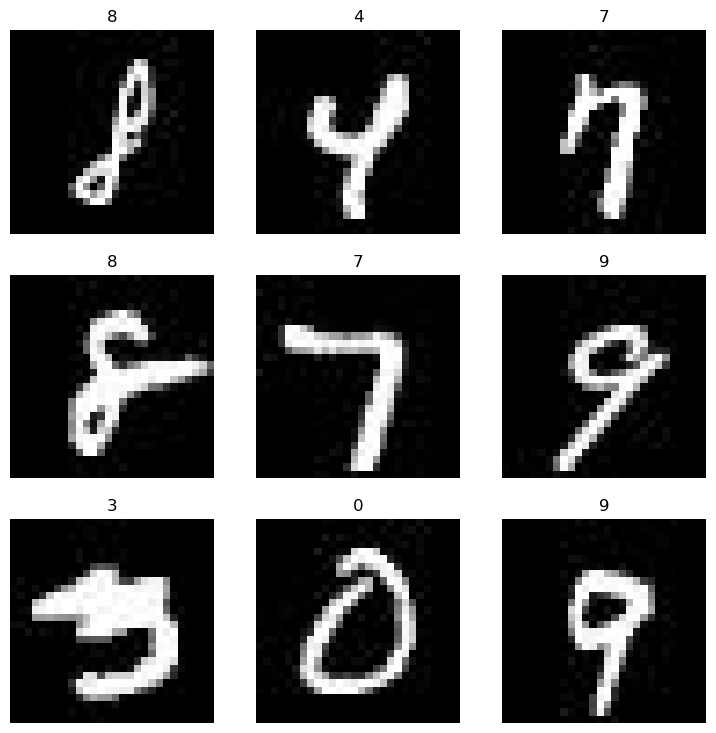

In [ ]:
dls.show_batch()

In [ ]:
dls.n

1681

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.799451,1.431905,0.459524,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.452900,1.000913,0.314286,00:08
1,1.127767,0.726985,0.219048,00:08
2,0.822714,0.569272,0.164286,00:08
3,0.580217,0.472451,0.142857,00:08
4,0.394636,0.403461,0.116667,00:08
5,0.281271,0.356165,0.102381,00:08
6,0.194676,0.374367,0.109524,00:08
7,0.137263,0.370997,0.107143,00:08
8,0.103021,0.350598,0.104762,00:08
9,0.083260,0.356768,0.107143,00:08


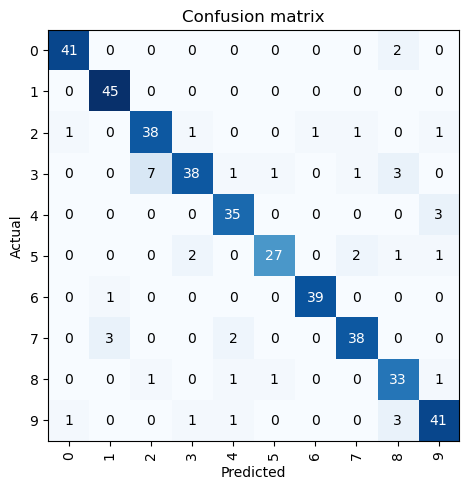

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

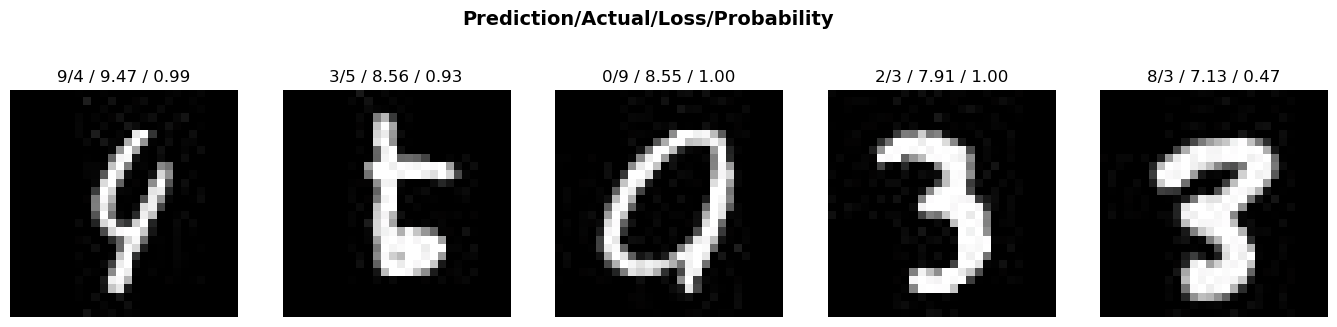

In [ ]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

We can correct images annotations or remove them, using the `ImageClassifierCleaner`. That will show the images for each class (in the train or validation set) where the trained model had the highest classification error. Let's import the required modules:

In [ ]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

Each time we make a change in one class's and data set's (train/validation) samples, by reannotating/removing it, we need to run the following lines before changing to another class or data set, so the changes are applied to the actual data:

In [ ]:
for ind in cleaner.delete(): cleaner.fns[ind].unlink()
for ind, cat in cleaner.change(): shutil.move(str(cleaner.fns[ind]), f"{train_dir}/{cat}")

In the end of validating the data, we need to create a new `DataLoaders` object, to reflect the changes made to the dataset, and retrain the model.

epoch,train_loss,valid_loss,error_rate,time
0,2.888510,1.503774,0.525301,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.519504,1.011998,0.330120,00:07
1,1.199548,0.672037,0.221687,00:07
2,0.866976,0.474139,0.137349,00:07
3,0.597648,0.332307,0.101205,00:07
4,0.420963,0.318540,0.096386,00:07
5,0.295351,0.311173,0.086747,00:07
6,0.213994,0.280651,0.081928,00:07
7,0.154817,0.255272,0.067470,00:07
8,0.112886,0.267510,0.069880,00:07
9,0.089455,0.275279,0.077108,00:07


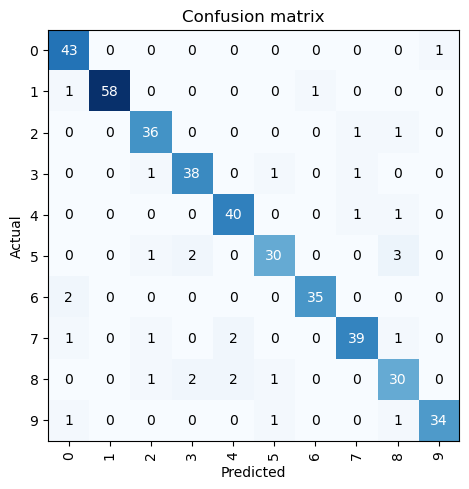

In [ ]:
dls = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items = get_image_files,
                get_y = parent_label,
                splitter = RandomSplitter()
               ).dataloaders(train_dir)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
dls.n

1662

## Test Model

In [ ]:
pd.read_csv("./data/mnist/sample_submission.csv").head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
test_dl = dls.test_dl(get_image_files(test_dir))
preds_probs = learn.get_preds(dl=test_dl)[0]  # probs

In [ ]:
preds = pd.Series(preds_probs.max(axis=1).indices, name="Label")
ids = pd.Series(data=[int(item.name[:-4])+1 for item in test_dl.dataset.items], name="ImageId")

In [ ]:
submission_df = pd.concat((ids, preds), axis=1).sort_values(by="ImageId")

In [ ]:
submission_df.head()

,ImageId,Label
27898,1,2
26377,2,0
24566,3,8
26165,4,9
21011,5,3


In [ ]:
submission_df.to_csv("./data/mnist/submission.csv", index=False)

We only used 5% of the data for training and validation, to make it faster, so, after iterating this process enough to be confident of our data processing and validation methods, and our model's architecture and hypeparameters, we would retrain and validate it on the whole dataset.

In [ ]:
from shutil import rmtree

rmtree(train_dir)
rmtree(test_dir)

# Animals

- The Pan African Programme: The Cultured Chimpanzee, Wild Chimpanzee Foundation, DrivenData. (2022). Conser-vision Practice Area: Image Classification. Retrieved [Month Day Year] from https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/.

## Load Data

In [ ]:
import pandas as pd

In [ ]:
labels = pd.read_csv("./data/animals/train-labels.csv")

In [ ]:
labels.head(2)

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
labels["label"] = labels.iloc[:, 1:].idxmax(axis=1).values
labels = labels[["id", "label"]].set_index("id")

In [ ]:
display(labels.head(2))
print(labels.shape)

,label
id,
ZJ000000,bird
ZJ000001,monkey_prosimian


(16488, 1)


In [ ]:
labels_sample = labels.groupby("label").sample(frac=0.05)["label"]

In [ ]:
labels_sample

id
ZJ009857    antelope_duiker
ZJ006205    antelope_duiker
ZJ015289    antelope_duiker
ZJ002203    antelope_duiker
ZJ008486    antelope_duiker
                 ...       
ZJ012387             rodent
ZJ008316             rodent
ZJ012197             rodent
ZJ004787             rodent
ZJ007973             rodent
Name: label, Length: 826, dtype: object

## Train Model

In [ ]:
from fastai.vision.all import *

In [ ]:
train_path = "./data/animals/train/"
test_path = "./data/animals/test/"

In [ ]:
def get_items(path):

    path = Path(path)
    res = []

    for filename in os.listdir(path):
        if filename[:-4] in labels_sample.index:
            res.append(path/filename)

    return L(res)

In [ ]:
dls = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                get_items=get_items,
                get_y=lambda x: labels_sample.loc[x.name[:-4]], 
                splitter=RandomSplitter(),
                item_tfms=Resize(128, method="squish"),
                batch_tfms=[Normalize.from_stats(*imagenet_stats)]
               ).dataloaders(train_path)

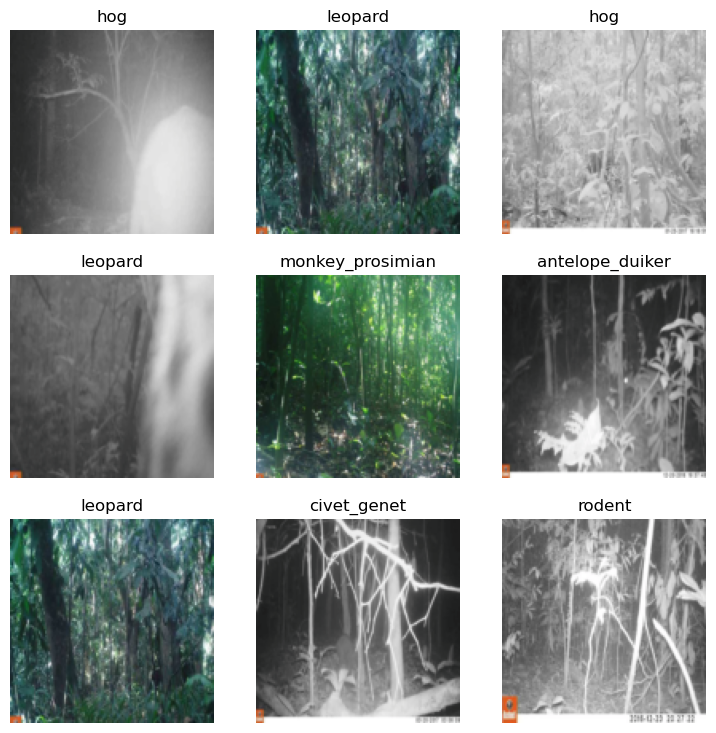

In [ ]:
dls.show_batch()

In [ ]:
dls.n

661

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,3.050437,2.190669,0.696970,00:10


epoch,train_loss,valid_loss,error_rate,time
0,1.883267,1.707361,0.551515,00:12
1,1.671480,1.513506,0.436364,00:12
2,1.359095,1.500973,0.460606,00:12
3,1.100571,1.569371,0.448485,00:11
4,0.877178,1.688496,0.460606,00:11
5,0.698931,1.693306,0.478788,00:11
6,0.563536,1.697963,0.430303,00:11
7,0.463716,1.748586,0.448485,00:11
8,0.376198,1.744868,0.448485,00:11
9,0.311529,1.747836,0.454545,00:11


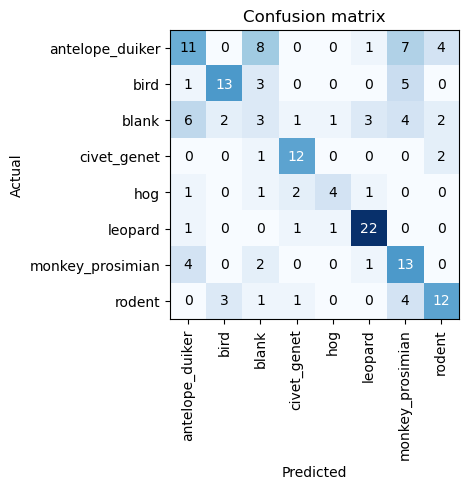

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

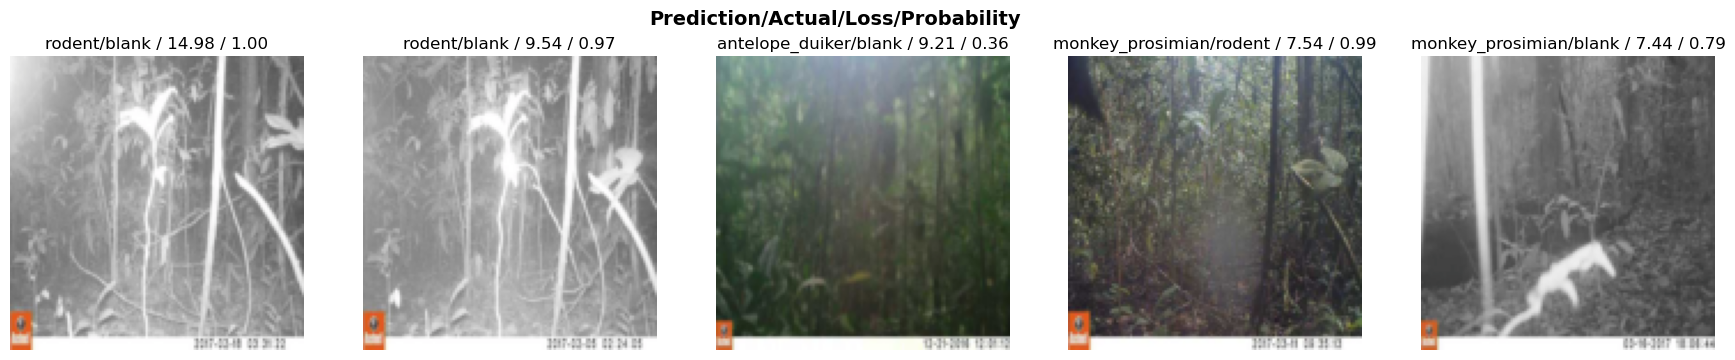

In [ ]:
interp.plot_top_losses(k=5, nrows=1, figsize=(22,4))

In [ ]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

I can't see enough to validate the images.

## Test Model

In [ ]:
pd.read_csv("./data/animals/sample-submission.csv").head()

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ016488,0.048233,0.189185,0.044914,0.199588,0.106118,0.132915,0.166410,0.112637
1,ZJ016489,0.097078,0.061400,0.026409,0.241530,0.144344,0.051780,0.287811,0.089648
2,ZJ016490,0.124658,0.089101,0.189225,0.174494,0.180540,0.079995,0.085672,0.076314
3,ZJ016491,0.109966,0.048397,0.055598,0.323600,0.322356,0.063252,0.008160,0.068671
4,ZJ016492,0.165742,0.184610,0.005431,0.136806,0.000389,0.122078,0.151521,0.233423


In [ ]:
test_dl = dls.test_dl(get_image_files(test_path))
preds_probs = learn.get_preds(dl=test_dl)[0]

In [ ]:
ids = np.array([item.name[:-4] for item in test_dl.dataset.items])

In [ ]:
learn.dls.vocab

['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']

In [ ]:
submission_df = pd.DataFrame(data=preds_probs, columns= learn.dls.vocab)
submission_df.insert(0, "id", ids)
submission_df.sort_values(by="id", inplace=True)

In [ ]:
submission_df.head()

,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
1901,ZJ016488,0.003612,6.942989e-04,0.323665,5.332318e-01,0.020963,0.100759,1.180175e-02,0.005273
1693,ZJ016489,0.026071,8.592082e-02,0.024220,4.086171e-03,0.834774,0.011074,1.285491e-02,0.000999
2752,ZJ016490,0.030828,5.230120e-02,0.045449,1.384969e-01,0.718519,0.003206,7.886172e-03,0.003315
2542,ZJ016491,0.000002,8.615297e-08,0.000002,3.867934e-07,0.000002,0.999990,9.170705e-07,0.000002
2254,ZJ016492,0.500051,1.019086e-02,0.049266,3.648468e-02,0.045658,0.003554,3.501456e-01,0.004649


In [ ]:
submission_df.to_csv("./data/animals/submission.csv", index=False)